In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader, random_split

from datasets import load_dataset
from transformers import BertTokenizer
import matplotlib.pyplot as plt

In [2]:
import re
import string
import multiprocessing
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# ✅ Download stopwords & wordnet for lemmatization
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

# ✅ Load Stopwords & Lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/utkarshgoyal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/utkarshgoyal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/utkarshgoyal/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"<.*?>", "", text)  # Remove HTML tags
    text = re.sub(r"https?://\S+|www\.\S+", "", text)  # Remove URLs
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces

    # ✅ Tokenize words, remove stopwords & apply lemmatization
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Remove stopwords & lemmatize

    return " ".join(words)

# Model

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SentimentBiLSTMAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers=1, output_size=1, dropout=0.7, use_pretrained_embeddings=None):
        super(SentimentBiLSTMAttention, self).__init__()

        # ✅ Use Pre-trained Embeddings if Available
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if use_pretrained_embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(use_pretrained_embeddings, freeze=False)

        # ✅ BiLSTM (Reduced `num_layers=1` to prevent overfitting)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )

        # ✅ Scaled Dot-Product Attention
        self.attn_Wq = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.attn_Wk = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.attn_Wv = nn.Linear(hidden_size * 2, hidden_size * 2)

        # ✅ Fully Connected Layer
        self.fc = nn.Linear(hidden_size * 2, output_size)

        # ✅ Dropout & LayerNorm
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_size * 2)

        # ✅ Weight Initialization
        nn.init.kaiming_uniform_(self.attn_Wq.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.attn_Wk.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.attn_Wv.weight, nonlinearity='relu')

    def forward(self, x, adversarial=False, delta=0.02):
        embedded = self.embedding(x)

        # ✅ Apply Adversarial Noise
        if adversarial:
            noise = delta * torch.randn_like(embedded, requires_grad=True).to(embedded.device)
            embedded = embedded + noise  # Add perturbation

        lstm_out, _ = self.lstm(embedded)

        # ✅ Scaled Dot-Product Attention
        Q = self.attn_Wq(lstm_out)
        K = self.attn_Wk(lstm_out)
        V = self.attn_Wv(lstm_out)

        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / (K.size(-1) ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        context_vector = torch.matmul(attn_weights, V)

        # ✅ Mean Pooling
        context_vector = torch.mean(context_vector, dim=1)

        # ✅ Apply LayerNorm & Dropout
        context_vector = self.layer_norm(context_vector)
        context_vector = self.dropout(context_vector)

        # ✅ Fully Connected Layer
        out = self.fc(context_vector)

        return out

In [11]:
# 3. Implement Early Stopping
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001, save_path="best_model.pth"):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.save_path = save_path

    def check(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.save_path)  # ✅ Save best model
            return False  # Continue training
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Early stopping triggered after {self.counter} epochs. Loading best model...")
                model.load_state_dict(torch.load(self.save_path, weights_only=True))  # ✅ Restore best model
                return True  # Stop training
            return False

In [12]:
# ✅ Training Function with Adversarial Training & Graphing
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs, delta=0.02):
    early_stopping = EarlyStopping(patience=3, min_delta=0.001)
    best_val_loss = float('inf')

    # Lists to track metrics
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0

        for batch in train_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # ✅ Standard Forward Pass
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)
            
            # ✅ Adversarial Training (Generate Perturbed Embeddings)
            outputs_adv = model(inputs, adversarial=True, delta=delta).squeeze(1)
            loss_adv = criterion(outputs_adv, labels)
            
            # ✅ Combined Loss (Standard + Adversarial)
            total_loss = loss + 0.5 * loss_adv  # 50% normal, 50% adversarial
            total_loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)  # Gradient Clipping
            optimizer.step()

            running_loss += total_loss.item()
            preds = torch.round(torch.sigmoid(outputs)).detach()
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train

        # Store training metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # ✅ Validation Phase (No Adversarial Noise Here)
        model.eval()
        running_val_loss, correct_val, total_val = 0.0, 0, 0
        
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs).squeeze(1)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                
                preds = torch.round(torch.sigmoid(outputs))
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)
        
        val_loss = running_val_loss / len(val_loader)
        val_acc = correct_val / total_val

        # Store validation metrics
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        scheduler.step(val_loss)  # Reduce LR if validation loss stagnates

        # ✅ Save Best Model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")

        # ✅ Dynamic Dropout Adjustment
        if val_loss > best_val_loss:
            model.dropout.p = min(model.dropout.p + 0.05, 0.7)

        # ✅ Early Stopping Check
        if early_stopping.check(val_loss, model):
            break  # Stop training if no improvement

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # ✅ Load Best Model After Training
    model.load_state_dict(torch.load("best_model.pth", weights_only=True))

    # ✅ Plot Training Results
    plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies)

# ✅ Function to Plot Training & Validation Performance
def plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # ✅ Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()

    # ✅ Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy")
    plt.plot(epochs, val_accuracies, label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()

    plt.show()

# IMDB

In [13]:
# 1. Load and preprocess the data
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Use the Amazon Polarity dataset from Hugging Face.
# We use the provided 'train' split for training and 'test' as our validation set.
train_dataset = load_dataset("imdb", split="train")
val_dataset = load_dataset("imdb", split="test")

def preprocess_data(examples):
    # Apply text cleaning
    cleaned_texts = [clean_text(text) for text in examples["text"]]

    # Tokenize cleaned text
    tokens = tokenizer(cleaned_texts, padding="max_length", truncation=True, max_length=512, return_tensors="pt")

    return {"input_ids": tokens["input_ids"], "label": torch.tensor(examples["label"]).float()}

# Apply preprocessing to both training and validation datasets
train_tokenized = train_dataset.map(preprocess_data, batched=True, num_proc=multiprocessing.cpu_count() // 2)
val_tokenized = val_dataset.map(preprocess_data, batched=True, num_proc=multiprocessing.cpu_count() // 2)

# Convert lists of input_ids and labels into tensors and create TensorDatasets.
# (Note: The tokenizer returns lists, so we use torch.stack to combine them.)
X_train = torch.stack([torch.tensor(x) for x in train_tokenized["input_ids"]])
y_train = torch.tensor(train_tokenized["label"]).float()
train_tensor_dataset = TensorDataset(X_train, y_train)

X_val = torch.stack([torch.tensor(x) for x in val_tokenized["input_ids"]])
y_val = torch.tensor(val_tokenized["label"]).float()
val_tensor_dataset = TensorDataset(X_val, y_val)

# Create DataLoaders for training and validation.
batch_size = 64
train_loader = DataLoader(train_tensor_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_tensor_dataset, batch_size=batch_size, pin_memory=True)

# Get vocabulary size from the tokenizer (BERT-base-uncased has vocab size 30522)
VOCAB_SIZE = tokenizer.vocab_size

In [14]:
# 3. Improved Hyperparameters
embedding_dim = 100  # Unchanged
hidden_size = 128    # Reduced from 128 to 64 (simpler model)
num_layers = 2       # Reduced from 2 to 1 (prevent overfitting)
output_size = 1      # Binary classification
dropout = 0.7        # Increased from 0.5 to 0.6 for better regularization

device = torch.device("mps")
model = SentimentBiLSTMAttention(VOCAB_SIZE, embedding_dim, hidden_size,
                                 num_layers, output_size, dropout).to(device)

# 4. Improved Loss, Optimizer, and Scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-6)  # 🔽 Reduced LR from 0.01 to 0.001
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)  # 🔽 Reduced patience

Epoch 1/10: Train Loss: 1.0794, Train Acc: 0.5034, Val Loss: 0.6931, Val Acc: 0.5090
Epoch 2/10: Train Loss: 0.9499, Train Acc: 0.6096, Val Loss: 0.5173, Val Acc: 0.7450
Epoch 3/10: Train Loss: 0.7050, Train Acc: 0.7801, Val Loss: 0.4465, Val Acc: 0.7886
Epoch 4/10: Train Loss: 0.5970, Train Acc: 0.8247, Val Loss: 0.4318, Val Acc: 0.8026
Epoch 5/10: Train Loss: 0.5178, Train Acc: 0.8527, Val Loss: 0.3817, Val Acc: 0.8284
Epoch 6/10: Train Loss: 0.4611, Train Acc: 0.8736, Val Loss: 0.3713, Val Acc: 0.8376
Epoch 7/10: Train Loss: 0.4153, Train Acc: 0.8896, Val Loss: 0.3586, Val Acc: 0.8424
Epoch 8/10: Train Loss: 0.3785, Train Acc: 0.9000, Val Loss: 0.3730, Val Acc: 0.8434
Epoch 9/10: Train Loss: 0.3527, Train Acc: 0.9079, Val Loss: 0.3839, Val Acc: 0.8337
Early stopping triggered after 3 epochs. Loading best model...


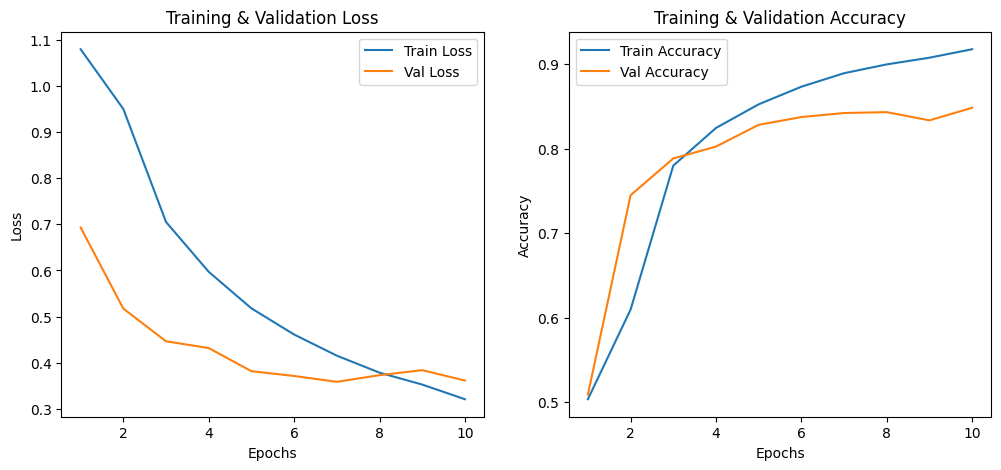

In [15]:
epochs = 10
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs)

# Amazon

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
# Load Dataset
train_dataset = load_dataset("amazon_polarity", split="train")
val_dataset = load_dataset("amazon_polarity", split="test")

# Load Tokenizer (BERT)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Faster Tokenization with Parallel Processing
def preprocess_data(examples):
    tokens = tokenizer(examples["content"], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    return {"input_ids": tokens["input_ids"], "label": examples["label"]}

# Apply Preprocessing in Parallel
train_tokenized = train_dataset.map(preprocess_data, batched=True, num_proc=multiprocessing.cpu_count() // 2)
val_tokenized = val_dataset.map(preprocess_data, batched=True, num_proc=multiprocessing.cpu_count() // 2)

# Convert to TensorDataset and Move to GPU
X_train = torch.tensor(train_tokenized["input_ids"]).to(device)
y_train = torch.tensor(train_tokenized["label"]).float().to(device)
train_tensor_dataset = TensorDataset(X_train, y_train)

X_val = torch.tensor(val_tokenized["input_ids"]).to(device)
y_val = torch.tensor(val_tokenized["label"]).float().to(device)
val_tensor_dataset = TensorDataset(X_val, y_val)

# Faster DataLoader with `pin_memory=True`
batch_size = 128
train_loader = DataLoader(train_tensor_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_tensor_dataset, batch_size=batch_size, pin_memory=True)

# Get Vocabulary Size
VOCAB_SIZE = tokenizer.vocab_size